# Bead plots

In [21]:
import pandas as pd
import numpy as np
excel = pd.read_excel('../../OPT Shared files/2_Saved reconstructions/fd_focal scan/bead profiles.xlsx')
excel.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52
0,Bead x,81.0,NaN,NaN,NaN,236.0,NaN,NaN,NaN,411.0,...,NaN,NaN,505.0,NaN,NaN,NaN,332.0,NaN,NaN,NaN
1,Bead y,691.0,NaN,NaN,NaN,618.0,NaN,NaN,NaN,348.0,...,NaN,NaN,509.0,NaN,NaN,NaN,904.0,NaN,NaN,NaN
2,Slice,4.0,NaN,NaN,NaN,597.0,NaN,NaN,NaN,595.0,...,NaN,NaN,1291.0,NaN,NaN,NaN,466.0,NaN,NaN,NaN
3,NaN,0.0,1.5000,0.0,0.0,0.0,38.000,0.0,0.0,0.0,...,0.0,0.0,0.0,42.917,0.0,7.778,0.0,12.750,0.0,0.0
4,NaN,1.0,1.8738,1.0,0.0,1.0,65.091,1.0,0.0,1.0,...,1.0,0.0,1.0,49.038,1.0,12.121,1.0,4.661,1.0,0.0


## Bead visualisation

Rotate image based on 

$$\theta = \arctan(\frac{y-c}{x-c})$$

where $c$ is the central coordinate.

In [22]:
image_size = 1038
c = image_size //2
e = 6.45/1000 # pixel_size in mm

# extract 
x = excel.iloc[0].dropna().values[1:].astype(np.float64)
y = 2*c - excel.iloc[1].dropna().values[1:].astype(np.float64)
slice = excel.iloc[2].dropna().values[1:].astype(np.int16)

angles = np.arctan2((y-c), (x-c))*180/np.pi
r = np.sqrt((x-c)**2 + (y-c)**2)*e
print(r)

[3.03512082 1.93381714 1.3045115  1.05231903 0.47890979 0.53538885
 1.97740632 2.75770502 1.33029589 0.86699133 2.93925446 0.11097
 2.76067535]


In [23]:
len(slice)

13

In [24]:
selected = [2,  4,6, -2, -3]

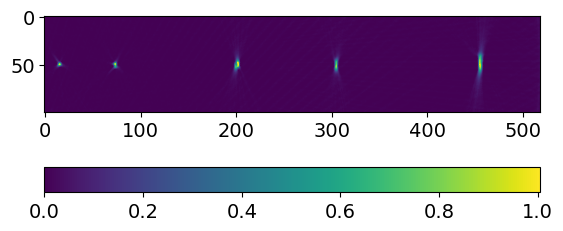

In [25]:
from skimage import io
from skimage.transform import rotate
import matplotlib.pyplot as plt
padded_slice = [str(x).zfill(4) for x in slice]
dy = 50

final_image = np.zeros((image_size, image_size))
for i in selected:
    im = io.imread(f'../../OPT Shared files/2_Saved reconstructions/fd_focal scan/fd_infocus/reco{padded_slice[i]}.tif')
    rotated_image = rotate(im, -angles[i])
    final_image += rotated_image/ np.max(rotated_image[c-dy:c+dy, c:])


plt.imshow(final_image[c-dy:c+dy:, c: ])
plt.colorbar(location='bottom')

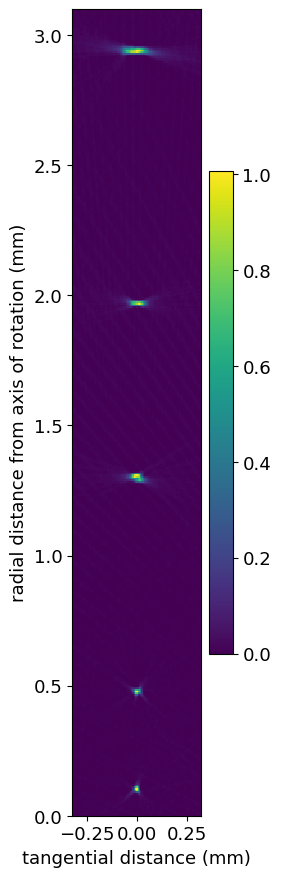

In [26]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(3,9))
x_grid = (np.arange(c, image_size) - c)*e
y_grid = np.arange(-dy, dy)*e
plt.pcolormesh(y_grid, x_grid, final_image[c-dy:c+dy:, c: ].T)
plt.ylabel('radial distance from axis of rotation (mm)')
plt.xlabel('tangential distance (mm)')
plt.colorbar(location='right')
plt.ylim(0, 3.1)
plt.tight_layout()

## Bead profiles

In [ ]:
# Generate Gaussian profiles
def gaussian(x, sigma):
    return np.exp(-x**2/(2*sigma**2))

def top_hat(x):
    hat = np.zeros(len(x))
    hat[np.abs(x)<7.5] = 1
    return hat

from numpy.fft import fft, ifft, fftshift, fftfreq

freqs = np.arange(-200, 200)
profile = gaussian(freqs, 23)
profile_wide = gaussian(freqs, 80)

x = fftshift(fftfreq(len(freqs))) * 1000
psf_1 = fftshift(np.abs(fft(profile)))
psf_2 = fftshift(np.abs(fft(profile_wide)))
bead = 100*top_hat(x)

bead_transform = np.abs(fftshift(fft(bead)))
multiplied = bead_transform * profile
multiplied_2 = bead_transform * profile_wide

convolved = fftshift(np.abs(ifft(multiplied)))
convolved_2 = fftshift(np.abs(ifft(multiplied_2)))

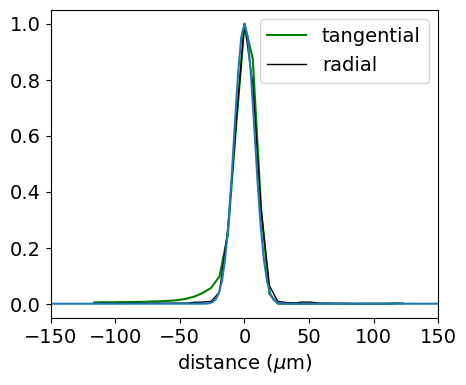

In [40]:
def range_from_profile(array):
    return (np.arange(0,len(array))-np.argmax(array)) * e*1000
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(5,4))
small_tangential = excel.iloc[:,4*11+2].dropna()
plt.plot(range_from_profile(small_tangential),  small_tangential/small_tangential.max(), 'g-', label='tangential', )
small_radial = excel.iloc[:,4*11+4].dropna()
plt.plot(range_from_profile(small_radial), small_radial/small_radial.max(), color='black', lw=1, label = 'radial')
plt.legend()
plt.xlim(-150, 150)
plt.xlabel('distance ($\mu$m)')

plt.plot(x, convolved/convolved.max())


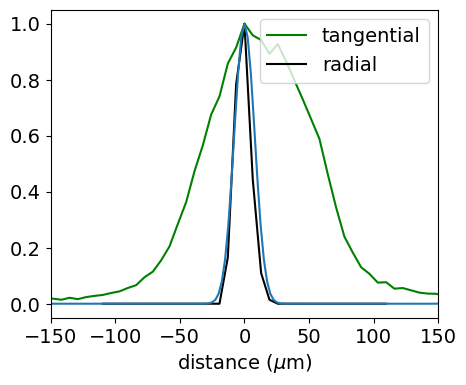

In [37]:
plt.figure(figsize=(5,4))
big_tangential = excel.iloc[:,10*4+2].dropna()
big_radial = excel.iloc[:,10*4+4].dropna()
plt.plot(range_from_profile(big_tangential), big_tangential/big_tangential.max(), 'g-', label='tangential')
plt.plot(range_from_profile(big_radial), big_radial/big_radial.max(), color='black', label='radial')
plt.legend(loc='upper right')
plt.xlim(-150, 150)
plt.xlabel('distance ($\mu$m)')

## Fitting bid widths

Data processing step of extracting bead profiles from the excel dataset. 

In [ ]:
num_beads = (excel.shape[1] - 1)//4
num_beads
from scipy.optimize import curve_fit

tangentials = [] 
radials = []
for i in range(num_beads):
    array = excel.iloc[:,i*4+2].dropna().values
    tangentials.append(array)
    radial = excel.iloc[:,i*4+4].dropna().values
    radials.append(radial)
    # plt.plot(tangentials[i])
    # plt.plot(radials[i])

In [ ]:
def gaussian(x, mu, sigma, A):
    return A*np.exp(-((x-mu)**2/sigma**2 / 2))

In [ ]:
p0 = [0, 50, 1]
popt, pcov = curve_fit(gaussian, range_from_profile(big_tangential), big_tangential/big_tangential.max(), p0=p0)

In [ ]:
tangential_widths = []
tangential_width_errors = []
radial_widths = []

for i in range(num_beads):
    # tangential profiles
    array = tangentials[i]
    popt, pcov = curve_fit(gaussian, range_from_profile(array), array/array.max(), p0=p0)
    tangential_widths.append(popt[1])
    tangential_width_errors.append(np.sqrt(pcov[1,1]))
    # radial profiles
    array = radials[i]
    popt, pcov = curve_fit(gaussian, range_from_profile(array), array/array.max(), p0=p0)
    radial_widths.append(popt[1])

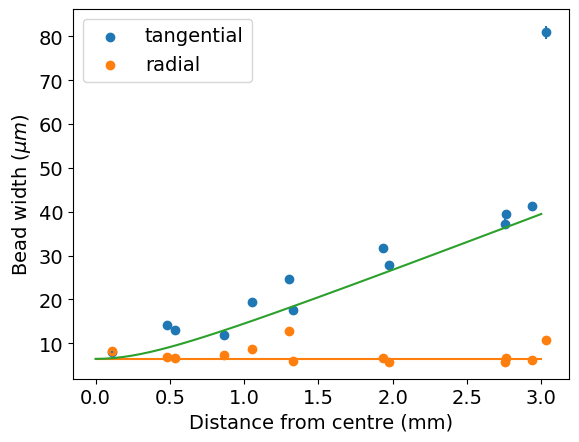

In [ ]:
def theoretical_radial_width(w0):
    return np.sqrt(w0**2/2)

def theoretical_tangential_width(r0, w0,lamb):
    return np.sqrt((w0*w0 + (lamb*r0/(np.pi*w0))**2 )/2)

r0 = np.linspace(0,3) # mm
lamb = 525/1000 # um
w0 = 9.1

plt.errorbar(r, tangential_widths, yerr=tangential_width_errors, ls='')
plt.ylabel('Bead width ($\mu m$)')
plt.xlabel('Distance from centre (mm)')
plt.scatter(r, tangential_widths, label= 'tangential')
plt.scatter(r, radial_widths, label='radial')
plt.plot(r0, theoretical_radial_width(w0) + r0*0)

plt.plot(r0, theoretical_tangential_width(r0*1000, w0, lamb))
plt.legend()

In [ ]:
r

array([3.03512082, 1.93381714, 1.3045115 , 1.05231903, 0.47890979,
       0.53538885, 1.97740632, 2.75770502, 1.33029589, 0.86699133,
       2.93925446, 0.11097   , 2.76067535])

[0.85168477 8.16265709 0.99447738]


(-30.0, 30.0)

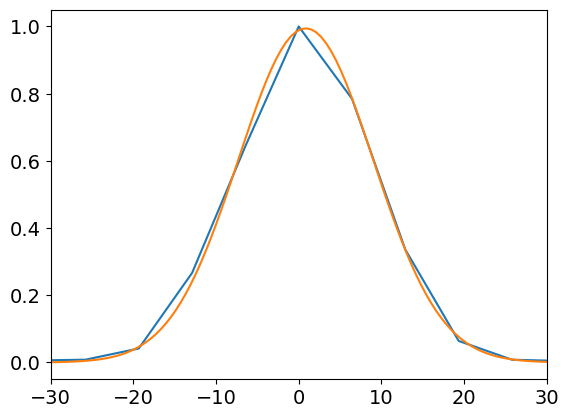

In [ ]:
popt, pcov = curve_fit(gaussian, range_from_profile(small_radial), small_radial/small_radial.max(), p0=p0)
xs = range_from_profile(small_radial)
plt.plot(xs, small_radial/small_radial.max())
# plt.plot(xs, gaussian(xs, 0, 15, 1))
x_range = np.linspace(-30, 30, 100)
plt.plot(x_range, gaussian(x_range, *popt))
print(popt)
plt.xlim(-30, 30)

FWHM is $2.355 \sigma$. 

In [ ]:
2.355*popt[1]

19.223057455199935

To get PSF width

In [ ]:
np.sqrt((2.355*popt[1])**2 - 15**2)

12.021894107249398